<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/TrainingDataForDemosaicking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Data for Demosaicking
#### Qian, Mar 16



Idea: start with demosaicking to test synthetic images. Can start with single frame demosaicking and proceed to multiframe demosaicking.

Goal: 
* model trained on the synthetic data is able to extend to real data
* model trained on local patches works on whole frames

Reference: [Deep Joint Demosaicking and Denoising](https://groups.csail.mit.edu/graphics/demosaicnet/data/demosaic.pdf)

Notation: 
* J: ground truth colored frame/features
* I: mosaiced frame/features

single-frame pipeline: *J* -> mosaic model -> *I* -> network -> *J_est*

multiframe general pipeline: 
$$J_t \rightarrow \text{mosaic model} \rightarrow  I_t$$ 
$$ \{I_t, I^{w*}_{t-1}, \dots, I^{w*}_{t-T}\}\rightarrow \text{network} \rightarrow J_t^{est}$$

multiframe recurrent pipeline: 
$$J_t \rightarrow \text{mosaic model} \rightarrow  I_t$$ 
$$ \{I_t, J^{w*}_{t-1}\}\rightarrow \text{network} \rightarrow J_t^{est}$$

\* In order to achieve the 2nd goal, reference frames in the multiframe pipeline are pre-warpped.

## Training with compressed features: coupled autoencoder preprocessing pipeline

As inputs (mosaiced frame) and outputs (colored frame) probably do not share common weights to extract their separate features, we can train one autoencoders for each to extract features. After two networks are trained, we can preprocess the data on both ends and build a demosaicing network that maps input features to output features.

a mosaiced autoencoder can be formulated as:
$$h_M = f^M_{enc}(I)$$
$$\hat{I} = f^M_{dec}(h_M)$$

a colored autoencoder can be formulated as:
$$h_C = f^C_{enc}(J)$$
$$\hat{J} = f^C_{dec}(h_C)$$

M stands for "mosaiced", C stands for "colored" and h stands for compressed features. Two networks can share an architecture but are expected to have separate weights.

The demosaicking network can be formulated as:
$$\hat{h_C} = f^D(h_M)$$

we can first try MSE loss when training three networks.

Anticipated results:
* should demonstrate demosaicking efficiency.
* should improve runtime.


## Using pretrained autoencoder

Questions to be answered before searching:

* why do we apply a pretrained model trained with natural images

    *Comments: pretrained autoencoders learned a natural feature space, which can decompose Blender outputs into natural features. In this way unnatural contents caused by Blender scenes inperfections are eliminated. Also a network trained with tons of natural training images is minimally impacted by "noise" in each image, including shot noise, sensor sampling, quantization, read-out noise, compression, etc.*

* how to transform mosaiced image to legitimate input format (typically non-linear RGB of larger resolution) required by the pretrained autoencoder

    *Comments: unpack the bayer image into matrix below, and fill the empty slots with 0s or nearest neighbor values. But how to deal with non-linearity?*
    
    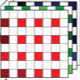

Desirable autoencoder properties:
* pre-trained on natural image databases (e.g., Imagenet)
* if cannot find one, a common practice is to get pre-trained encoder in other tasks (e.g., VGG19 in classification) and train a decoder with the same dataset using transfer learning techniques.

Natural image datasets:
* [UPENN NATURAL IMAGE DATABASE](https://web.sas.upenn.edu/upennidb/) w/ luminance & RGB
* [web collection](https://www.visionscience.com/vsImages.html)


## Training Data in Blender 

In [ ]:
! unzip -q drive/MyDrive/blender_frames_noisefree.zip

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
os.chdir("Image/")

In [ ]:
def print_stat(narray, narray_name = "Array"):
    print(narray_name, "shape: ", narray.shape, "dtype:", narray.dtype)
    arr = narray.flatten()
    print(narray_name , "stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

In [ ]:
def load_exr(path):
    img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

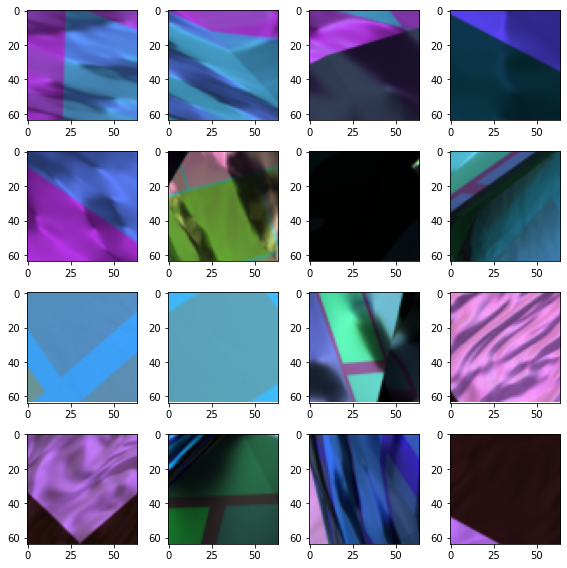

In [ ]:
m, n = 4, 4
fig, ax = plt.subplots(m, n, figsize = (8, 8))
for i in range(m):
    for j in range(n):
        img = load_exr("Image{:04d}.exr".format(i * n + j + 1))
        ax[i][j].imshow(img/img.max())
plt.tight_layout()
plt.show()

### ~~problem: not noise free in low light region~~

currently the number of samples should be quite high (81920) to approxiate noise-free frames. Each frame under this setting takes ~3 mins to render on my PC.

**Mar 17 update**: creating multiple threads on my PC produce wrong results.

In [ ]:
# img = cv2.imread("Image{:04d}.exr".format(24),cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# fig, ax = plt.subplots(1, 2, figsize = (8, 8))
# ax[0].imshow(img)
# ax[1].imshow(img/img.max())
# plt.show()
# print_stat(img)

## Mosaic Model

a simple pipeline to develop a mosaicked image from the field is: 

*field* -> noise model -> color filter array (CFA) -> *mosaicked image*

as described in Brook's [paper](https://arxiv.org/pdf/1811.11127.pdf). [Sumner](https://www.cnba.it/contenuti/uploads/2016/03/Processing-RAW-Images-in-MATLAB-Sumner.pdf) includes "linearization" and "white balance" blocks before CFA, which can be either unnecessary for Blender outputs (as sensor response are already linearized) or can be interchangeably moved after CFA.

Some parameters and configurations are adapted from Evetar lens( 25mm, F/2.4) and CMOS image sensor (Sony IMX274 4K). But some (like the amplitude factor between the light intensity and the pixel response is intractable) are set without the reference of the camera but considered along with the synthetic data properties.

---
reference: [link](https://photo.stackexchange.com/questions/72505/what-does-linearization-mean-in-raw-processing/92367), [link](https://www.rcsumner.net/raw_guide/)

### Noise Model

signal-dependent noise model, i.e., 
$y = \mathcal{N}(x, \sigma^2 = \sigma_r^2 + \sigma_s x)$, where  
- $y$: measurement
- $x$: groundtruth
- $\sigma_r$: read noise coefficient
- $\sigma_s$: shot noise coefficient


### CFA
apply Bayer filter and follow RGGB pattern.

In [ ]:
class camMosaicModel:
    def __init__(self):
        ''' params that are from experiments on EVETAR camera '''
        self.sigma_r = 5.3e-4
        self.sigma_s = 8.9e-5
        self.bit_depth = 10
        self.black_level = 50
        ''' params that are NOT from experiments on EVETAR camera '''
        self.amplitude = 1000

    def noise_model(self, img_gt):
        '''
        follow the noise model of signal-dependent normal distribution
        '''
        sigma_noise = np.sqrt(self.sigma_r**2 + self.sigma_s*img_gt)
        noise = np.random.randn(*img_gt.shape) * sigma_noise
        img_noisy = img_gt + noise
        return img_noisy

    def rgb2bayer(self, img):
        '''
        filter a full RGB frame to be a raw frame.
        '''
        h, w, c = img.shape
        bayer_img = np.zeros((h, w))
        bayer_img[::2, ::2] = img[::2, ::2, 0]
        bayer_img[1::2, 1::2] = img[::2, ::2, 2]
        bayer_img[::2, 1::2] = img[::2, 1::2, 1]
        bayer_img[1::2, ::2] = img[1::2, ::2, 1]
        return bayer_img
    
    def develop(self, img_gt, is_clean = False):
        '''
        develop raw frame from ground truth via the noise model, quantization, CFA.
        '''
        if is_clean:
            img_noisy = img 
        else:
            img_noisy = self.noise_model(img_gt)
        sensor_noisy = np.clip(np.round(img_noisy * self.amplitude) + self.black_level,
                               0, 2**self.bit_depth)
        sensor_noisy_float = (sensor_noisy - self.black_level)/(2**self.bit_depth - self.black_level)
        bayer_noisy = self.rgb2bayer(sensor_noisy)
        bayer_noisy_float = self.rgb2bayer(sensor_noisy_float)
        return sensor_noisy.astype(np.uint16), sensor_noisy_float, bayer_noisy.astype(np.uint16), bayer_noisy_float

## Generate Training pairs via Mosaic Model



### ground truth frame $J$

Array shape:  (64, 64, 3) dtype: float32
Array stat: max: 0.2783203125, min: 0.00836944580078125, mean: 0.07761788368225098, std: 0.04950729385018349
Dynamic range is 5.1 bits


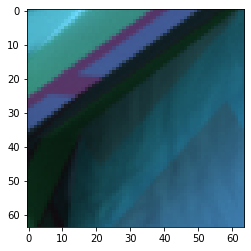

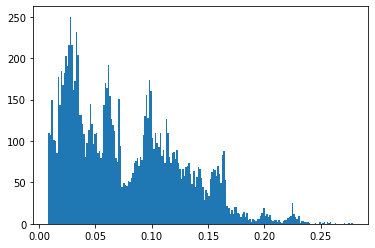

In [ ]:
img = load_exr("Image0008.exr")
print_stat(img)
print("Dynamic range is {:.1f} bits".format(np.log2(img.max()/img.min())))
plt.imshow(img/img.max())
plt.show()
plt.hist(img.flatten(), bins=200)
plt.show()

display bright area and dark area

Array shape:  (16, 16, 3) dtype: float32
Array stat: max: 0.2783203125, min: 0.0599365234375, mean: 0.1497262716293335, std: 0.05826051905751228
Array shape:  (16, 16, 3) dtype: float32
Array stat: max: 0.0771484375, min: 0.00926971435546875, mean: 0.02725558541715145, std: 0.015368307940661907


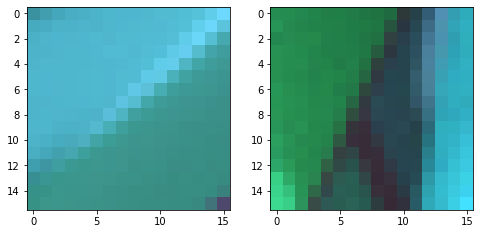

In [ ]:
print_stat(img[:16,:16])
print_stat(img[-16:, :16])
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(img[:16,:16]/img[:16,:16].max())
ax[1].imshow(img[-16:, :16]/img[-16:, :16].max())
plt.show()

### raw measurement $I$

In [ ]:
cam = camMosaicModel()
sensor_noisy, sensor_noisy_float, bayer_noisy, bayer_noisy_float = cam.develop(img)

camera measurement raw and distribution

Array shape:  (64, 64, 3) dtype: uint16
Array stat: max: 331, min: 56, mean: 127.63199869791667, std: 49.587773264518866


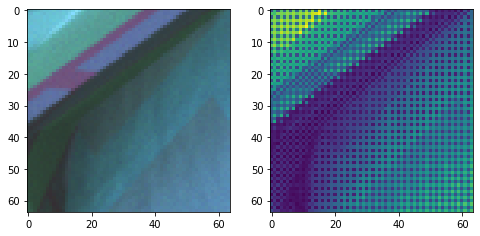

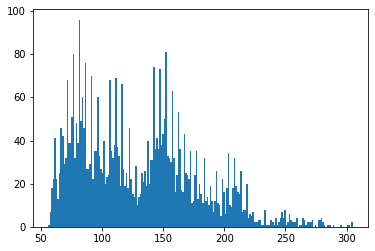

In [ ]:
print_stat(sensor_noisy)
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(sensor_noisy/sensor_noisy.max())
ax[1].imshow(bayer_noisy/bayer_noisy.max())
plt.show()
plt.hist(bayer_noisy.flatten(), bins=200)
plt.show()

same areas after applying camera model

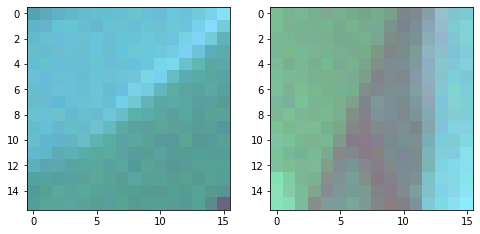

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(sensor_noisy[:16,:16]/sensor_noisy[:16,:16].max())
ax[1].imshow(sensor_noisy[-16:, :16]/sensor_noisy[-16:, :16].max())
plt.show()

## Autoencoder design and training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride = stride, padding=1, bias=True)

def deconv4x4(in_planes, out_planes, stride=2):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=stride, padding = 1, bias=True)

class mosaicAE(nn.Module):
    def __init__(self, in_planes, feature_planes):
        super(mosaicAE, self).__init__()
        ''' encoder'''
        self.conv1 = conv3x3(in_planes, 16, 2)
        self.conv2 = conv3x3(16, 32, 2)
        self.conv3 = conv3x3(32, feature_planes, 2)

        '''decoder'''
        self.deconv1 = deconv4x4(feature_planes, 32)
        self.deconv2 = deconv4x4(32, 32)
        self.deconv3 = deconv4x4(32, 32)
        self.conv4 = nn.Conv2d(32, in_planes, kernel_size=5, padding=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = F.relu(self.conv3(x))
        # x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = self.conv4(x)
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
in_planes = 3
feature_planes = 64
model = mosaicAE(in_planes, feature_planes).to(device)

In [ ]:
print("compression ratio -- {:.2f} : 1".format((8 * 8 * in_planes)/feature_planes))

compression ratio -- 3.00 : 1


In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# temp = model(torch.rand(4, 3, 32, 32).to(device))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, unnormalize = True):
    if unnormalize:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def load_exr(path):
        img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

### test functionality of mosaicAE: using CIFAR-10

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

KeyboardInterrupt: ignored

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _ = data
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('epoch [%d], loss: %.3f' %
                (epoch + 1, running_loss / i))
    running_loss = 0.0

print('Finished Training')

In [ ]:
with torch.no_grad():
    running_loss = 0.0
    total = 0
    for data in testloader:
        images, _ = data
        images = images.to(device)
        outputs = model(images).detach()
        total += 1
        running_loss += torch.mean((outputs - images)**2)
print('test loss: %.3f' %
                  (running_loss / total))
print('psnr: %.3f' %
                  (10*torch.log10(total/running_loss)))

test loss: 0.001
psnr: 28.551


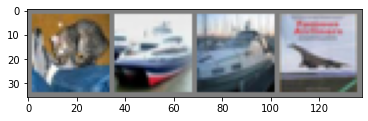

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


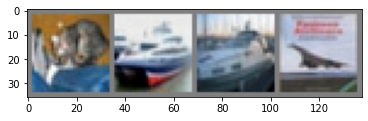

In [ ]:
dataiter = iter(testloader)
images, _ = dataiter.next()
outputs = model(images.to(device)).detach().cpu()
# show images
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(outputs))

display compressed features of the first test image

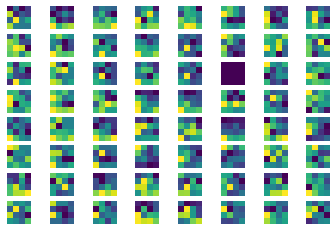

In [ ]:
## ref: https://discuss.pytorch.org/t/visualize-feature-map/29597/2

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv3.register_forward_hook(get_activation('conv3'))
outputs = model(images.to(device))

act = torch.clamp(activation['conv3'], 0, None).cpu().numpy()

fig, ax = plt.subplots(8, 8)
for i in range(8):
    for j in range(8):
        ax[i][j].imshow(act[0, i * 8 + j])
        ax[i][j].axis("off")
plt.show()

### train on synthetic data

In [ ]:
import os
import cv2


class SynDataset(torch.utils.data.Dataset):
    def __init__(self, root, train = True, transform = None):
        self.root = root
        self.train = train
        self.transform = transform

    def __len__(self):
        if self.train:
            return 240 * 8
        else:
            return 240 * 2
    
    def __getitem__(self, index):
        if self.train:
            X = load_exr(os.path.join(self.root, "scene{:02d}".format(index//240), 
                                  "Image", "Image{:04d}.exr".format(index % 240 + 1)))
        else:
            X = load_exr(os.path.join(self.root, "scene{:02d}".format(index//240 + 8), 
                                  "Image", "Image{:04d}.exr".format(index % 240 + 1)))
        X = torch.from_numpy(X.transpose(2, 0, 1)).float()
        return X

In [ ]:
# ! unzip -q drive/MyDrive/blender_4demosaic.zip

In [ ]:
trainset = SynDataset(root='/content', train=True, transform=None) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = SynDataset(root='/content', train=False, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


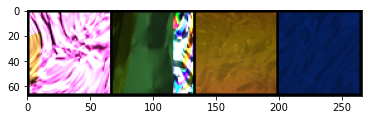

In [ ]:
dataiter = iter(trainloader)
images= dataiter.next()
imshow(torchvision.utils.make_grid(images), False)

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('epoch %d -- loss: %.3f' %
                (epoch + 1, running_loss / i))
    running_loss = 0.0

print('Finished Training')

epoch 1 -- loss: 0.109
epoch 2 -- loss: 0.049
epoch 3 -- loss: 0.034
epoch 4 -- loss: 0.036
epoch 5 -- loss: 0.032
epoch 6 -- loss: 0.025
epoch 7 -- loss: 0.025
epoch 8 -- loss: 0.027
epoch 9 -- loss: 0.024
epoch 10 -- loss: 0.019
epoch 11 -- loss: 0.027
epoch 12 -- loss: 0.015
epoch 13 -- loss: 0.017
epoch 14 -- loss: 0.017
epoch 15 -- loss: 0.016
epoch 16 -- loss: 0.017
epoch 17 -- loss: 0.020
epoch 18 -- loss: 0.022
epoch 19 -- loss: 0.015
epoch 20 -- loss: 0.011
Finished Training


test

In [ ]:
with torch.no_grad():
    running_loss = 0.0
    running_psnr = 0.0
    total = 0
    for data in testloader:
        images = data
        images = images.to(device)
        outputs = model(images).detach()
        total += 1
        running_loss += torch.mean((outputs - images)**2)
        running_psnr += 10 * torch.log10(images.max()/torch.mean((outputs - images)**2))
print('test loss: %.3f -- test psnr: %.2f' %
                  (running_loss / total, running_psnr/total))

test loss: 0.010 -- test psnr: 26.95


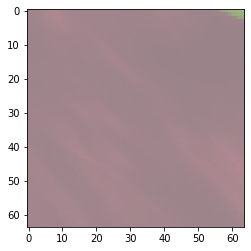

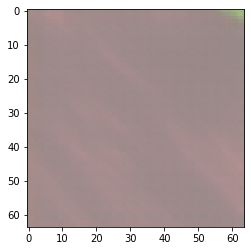

In [ ]:
dataiter = iter(testloader)
images = dataiter.next()
outputs = model(images.to(device)).detach().cpu()
# show images
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(outputs))

**has slight checkerboard artifacts**

## Demosaicking network

In [ ]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img, unnormalize = True):
    if unnormalize:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def load_exr(path):
        img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

In [ ]:
class BayerDemosaick(nn.Module):
  """Released version of the network, best quality.
  This model differs from the published description. It has a mask/filter split
  towards the end of the processing. Masks and filters are multiplied with each
  other. This is not key to performance and can be ignored when training new
  models from scratch.
  """
  def __init__(self, depth=15, width=64, pretrained=True, pad=False):
    super(BayerDemosaick, self).__init__()

    self.depth = depth
    self.width = width

    if pad:
      pad = 1
    else:
      pad = 0

    layers = OrderedDict([
        ("pack_mosaic", nn.Conv2d(3, 4, 2, stride=2)),  # Downsample 2x2 to re-establish translation invariance
      ])
    for i in range(depth):
      n_out = width
      n_in = width
      if i == 0:
        n_in = 4
      if i == depth-1:
        n_out = 2*width
      layers["conv{}".format(i+1)] = nn.Conv2d(n_in, n_out, 3, padding=pad)
      layers["relu{}".format(i+1)] = nn.ReLU(inplace=True)

    self.main_processor = nn.Sequential(layers)
    self.residual_predictor = nn.Conv2d(width, 12, 1)
    self.upsampler = nn.ConvTranspose2d(12, 3, 2, stride=2, groups=3)

    self.fullres_processor = nn.Sequential(OrderedDict([
      ("post_conv", nn.Conv2d(6, width, 3, padding=pad)),
      ("post_relu", nn.ReLU(inplace=True)),
      ("output", nn.Conv2d(width, 3, 1)),
      ]))

    # Load weights
    if pretrained:
      assert depth == 15, "pretrained bayer model has depth=15."
      assert width == 64, "pretrained bayer model has width=64."
      state_dict = torch.load(_BAYER_WEIGHTS)
      self.load_state_dict(state_dict)

  def forward(self, mosaic):
    """Demosaicks a Bayer image.
    Args:
      mosaic (th.Tensor):  input Bayer mosaic
    Returns:
      th.Tensor: the demosaicked image
    """

    # 1/4 resolution features
    features = self.main_processor(mosaic)
    filters, masks = features[:, 0:self.width], features[:, self.width:2*self.width]
    filtered = filters * masks
    residual = self.residual_predictor(filtered)

    # Match mosaic and residual
    upsampled = self.upsampler(residual)
    packed = torch.cat([mosaic, upsampled], 1)  # skip connection
    output = self.fullres_processor(packed)
    return output

In [ ]:
model = XTransDemosaick()
outputs = model(torch.rand(7, 4, 32, 32))

RuntimeError: ignored

## pretrained auto-encoder

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)

In [3]:
## https://pytorch.org/tutorials/beginne…
model = torchvision.models.vgg16(pretrained=True)

In [4]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
model.avgpool = Identity()
model.classifier = Identity()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
# outputs = model(torch.rand(7, 3, 64, 64)).view(7, 512, 2, 2)

In [6]:
def print_model_params(model):
    print("#total params:", sum(p.numel() for p in model.parameters()), end='')
    print(" | #trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

print_model_params(model)

#total params: 14714688 | #trainable params: 14714688


In [7]:
for param in model.parameters():
    param.requires_grad = False

In [8]:
print_model_params(model)

#total params: 14714688 | #trainable params: 0


In [22]:
from collections import OrderedDict
class upsampleBlock(nn.Module):
    def __init__(self, in_planes, out_planes, depth = 3, upsample = True):
        super(upsampleBlock, self).__init__()
        layers = OrderedDict([])
        for i in range(depth - 1):
            layers["conv{}".format(i+1)] = nn.Conv2d(in_planes, in_planes, 3, padding=1)
            layers["relu{}".format(i+1)] = nn.ReLU(inplace=True)
        layers["conv{}".format(depth)] = nn.Conv2d(in_planes, out_planes, 3, padding=1)
        layers["relu{}".format(depth)] = nn.ReLU(inplace=True)
        self.convBlock = nn.Sequential(layers)
        self.upsample = upsample

    def forward(self, x):
        x = self.convBlock(x)
        if self.upsample:
            x = F.upsample(x, scale_factor = 2)
        return x


class vggAutoencoder(nn.Module):
    def __init__(self, vgg_encoder):
        super(vggAutoencoder, self).__init__()
        self.vgg = vgg_encoder
        self.up0 = upsampleBlock(512, 512, depth = 1)
        self.up1 = upsampleBlock(512, 512)
        self.up2 = upsampleBlock(512, 256)
        self.up3 = upsampleBlock(256, 128)
        self.up4 = upsampleBlock(128, 64, depth = 2)
        self.up5 = upsampleBlock(64, 3, depth = 2, upsample = False)

    def forward(self, x):
        x = self.vgg(x).view(-1, 512, 2, 2)
        x = self.up0(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.up5(x)
        return x

In [23]:
vgg_ae = vggAutoencoder(model)
print_model_params(vgg_ae)

#total params: 31788675 | #trainable params: 17073987


In [24]:
outputs = vgg_ae(torch.rand(7, 3, 64, 64))
outputs.size()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3325: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([7, 3, 64, 64])